In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from glob import glob
import os, sys
from os import path

In [2]:
import matplotlib as mpl
import matplotlib.colors as DivergingNorm

mpl.rcParams.update({'font.size': 20})
mpl.rcParams['figure.figsize'] = (40.0, 8.0)


mpl.rcParams.update({'font.size': 40})

In [3]:
def read_back_num(string):
    marker = len(string)-1
    while not string[marker].isdigit(): marker -= 1
    end = marker + 1
    while string[marker:end].isdigit(): marker -= 1
    return int(string[marker + 1:end])

In [4]:
### CHANGE THIS TO YOUR LOCAL DIRECTORY ###
stats_dir = "/home/sajannr/rev02_ringmaps/trial_1"

# Get a list of all the stats files
fl_pattern = 'CSD_stats_out_fr{freq}.csv'
stats_files = glob(path.join(stats_dir, fl_pattern.format(freq = '*')))
print(len(stats_files))

1024


In [5]:
# Sort the files by frequency index
stats_files.sort(key = read_back_num)
freqs = [read_back_num(fl) for fl in stats_files]

In [6]:
def find_outliers(data, m = 5):
    mean = np.nanmean(data)
    std = np.nanstd(data)
    return np.where(np.abs(data - mean) < m * std)[0]

In [7]:
# Get the minimum and maximum of each stat for each frequency (and the corresponding CSD)
# This neglects some outliers, which can be changed 
stat_types = ['mean', 'median', 'stdev', 'skew', 'kurtosis', 'zsum', 'nonzero']

min_dict = {stat:[] for stat in stat_types}
max_dict = {stat:[] for stat in stat_types}

no_data_fr = []

for fr, stat_file in zip(freqs, stats_files):
    
    data = pd.read_csv(stat_file)
    
    if len(data) == 0:
        print(f"No data for frequency {fr}.", end = '\r')
        no_data_fr.append(fr)
        continue
        
    CSDs = data['CSD']
    for stat in stat_types:
        stat_data = data[stat]
        mask = find_outliers(stat_data, m = 5)
        if len(mask) == 0:
            print(f"No data for frequency {fr}.", end = '\r')
            no_data_fr.append(fr)
            continue
            
        min_index = np.nanargmin(stat_data[mask])
        max_index = np.nanargmax(stat_data[mask])        
        
        min_dict[stat].append((CSDs.iat[min_index], stat_data.iat[min_index]))
        max_dict[stat].append((CSDs.iat[max_index], stat_data.iat[max_index]))
    
    #print(fr, end = '\r')
    

In [8]:
# Get the (outlier removed) extrema across both day and frequency
min_list = []
max_list = []

key = lambda x: x[1]

for stat in stat_types:
    stat_summary = np.array(min_dict[stat])
    min_entry = min(stat_summary[find_outliers(stat_summary, m = 3)], key = key)
    max_entry = max(stat_summary[find_outliers(stat_summary, m = 3)], key = key)
    min_list.append(min_entry[1])
    max_list.append(max_entry[1])
    print(stat, min_entry, max_entry)
    

mean [2244.          -10.05180259] [1859.            3.30330987]
median [ 2.23500000e+03 -1.75967922e-01] [1.85900000e+03 1.10061261e-01]
stdev [2290.    0.] [2149.          415.68826278]
skew [ 2045.         -1358.05868291] [2310.          764.93070704]
kurtosis [2027.   -3.] [   2128.         1045203.53499828]
zsum [2.24200000e+03 2.32863045e-02] [2.15100000e+03 6.90124211e-01]
nonzero [2339.    0.] [1.80400000e+03 2.71972656e-01]


<ipython-input-6-3d4f83281a24>:4: RuntimeWarning: invalid value encountered in less
  return np.where(np.abs(data - mean) < m * std)[0]


In [ ]:
# Somewhat unfinished function to get data for a given day across different frequencies
csd_dict = {}
for fr, stat_file in zip(freqs, stats_files):
    
    data = pd.read_csv(stat_file)
    
    if len(data) == 0:
        print(f"No data for frequency {fr}.")
        continue
        
    CSDs = data['CSD']
    for i, csd in enumerate(CSDs):
        if not(csd in csd_dict):
            csd_dict[csd] = {stat : [] for stat in stat_types}
        for stat in stat_types:
            csd_dict[csd].append((fr, data[stat].iat[i]))
    
    print(fr, end = '\r')

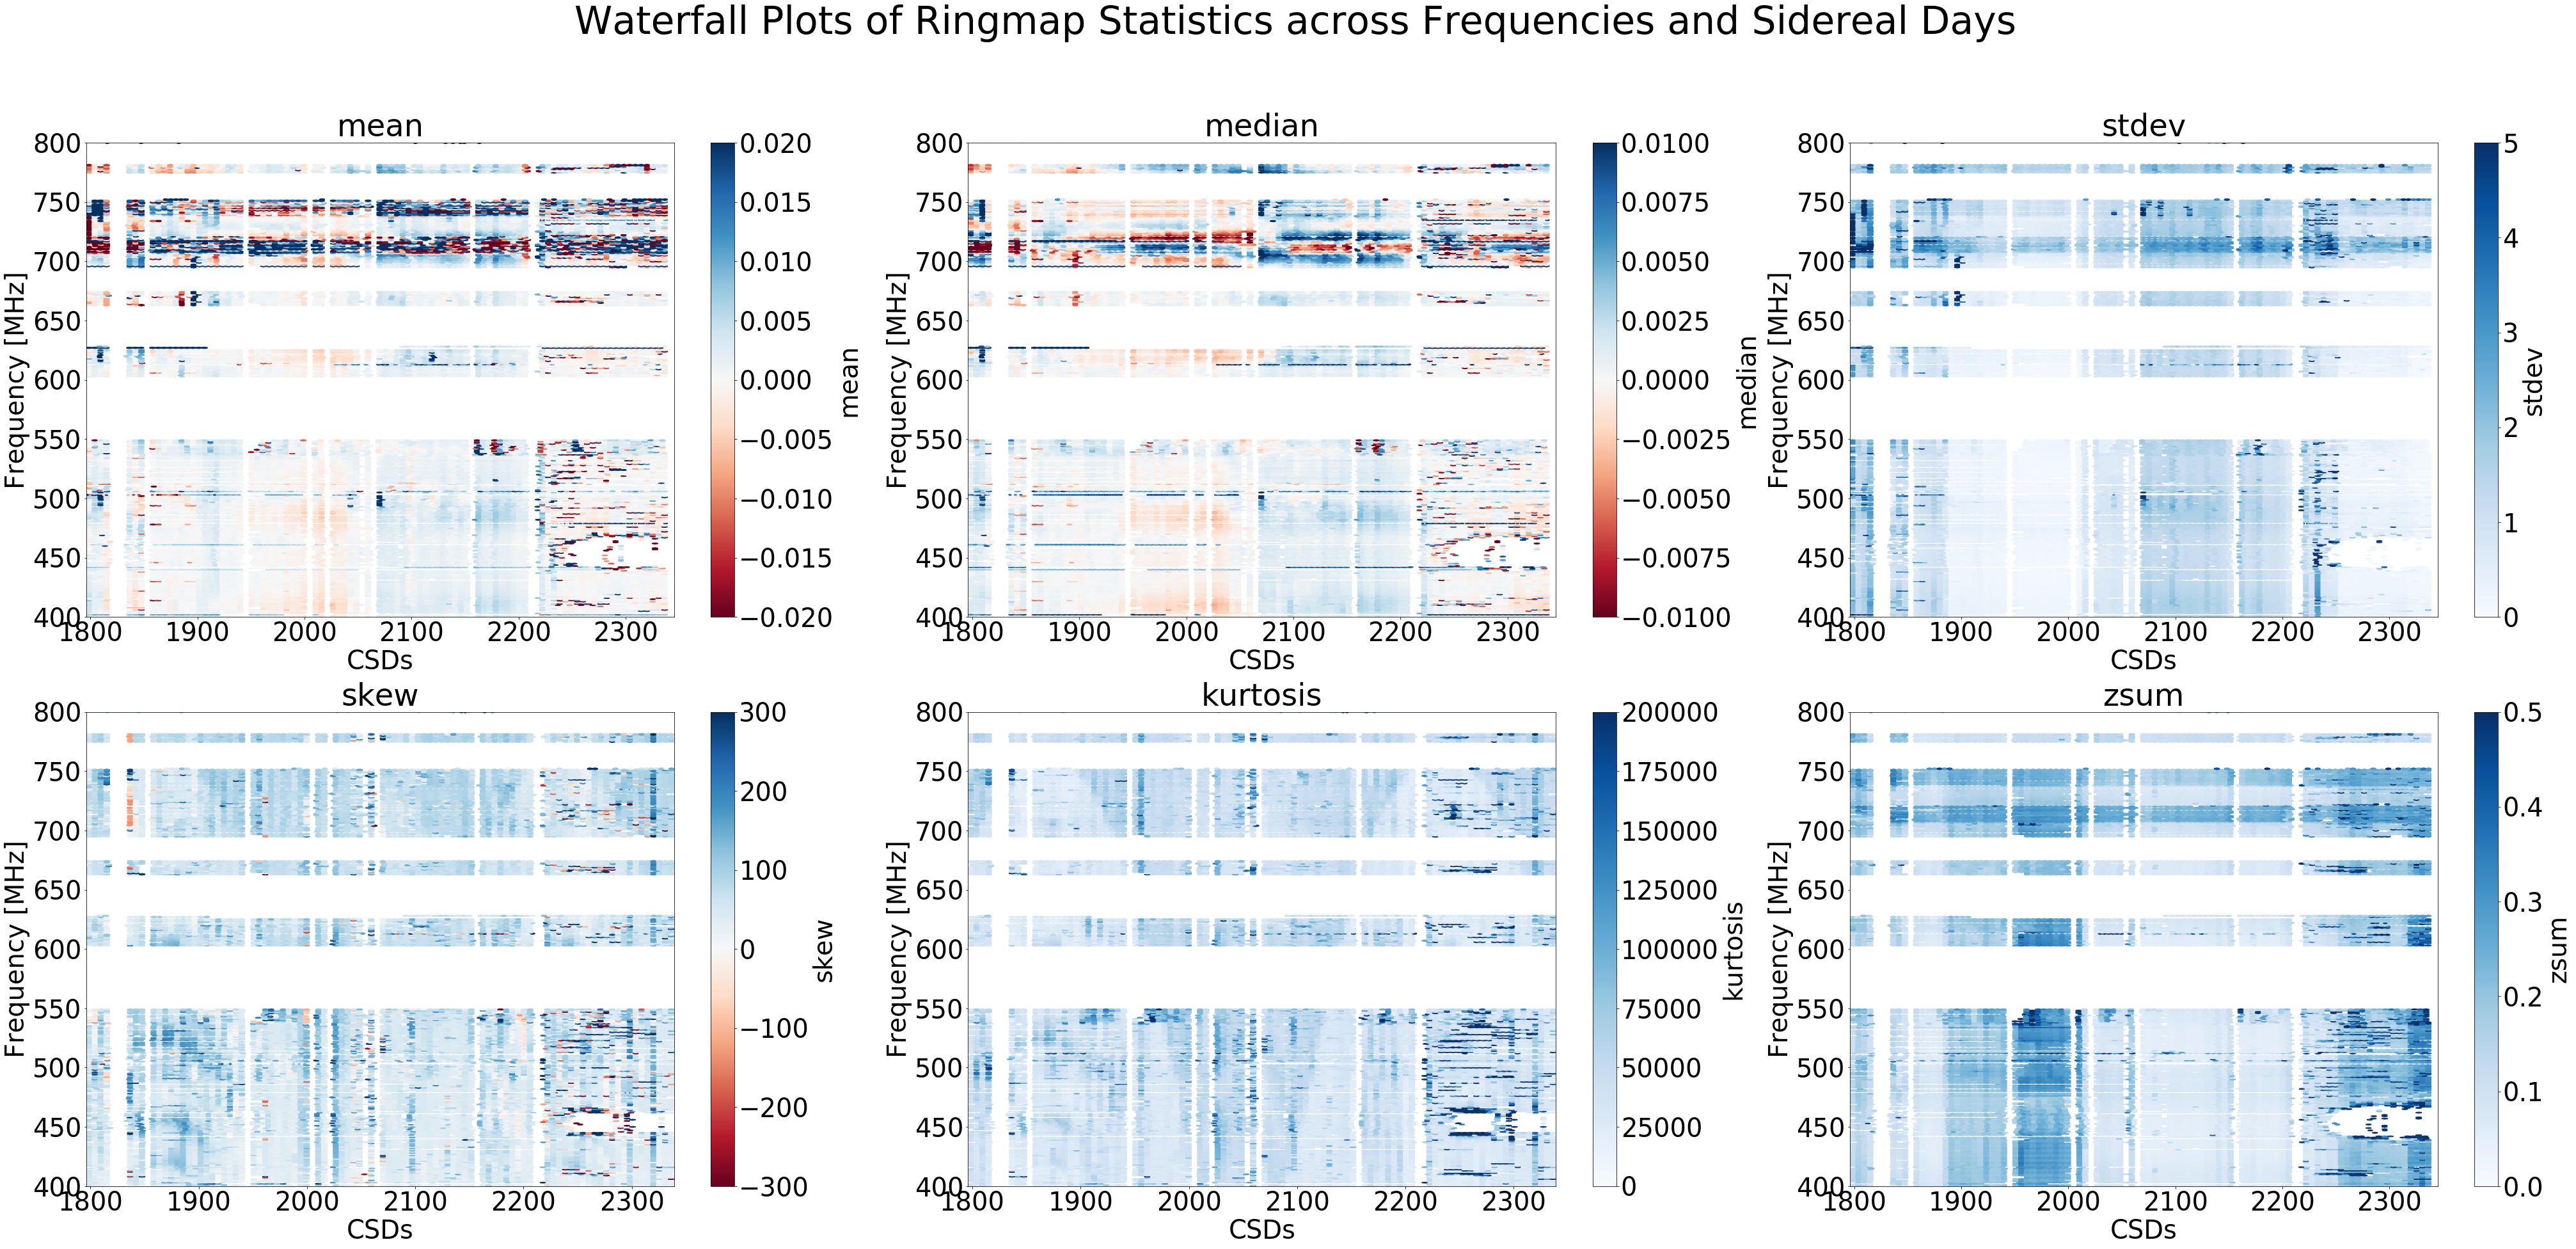

In [9]:
# Make some fancy waterfall plots
# Mess around with the vranges as needed

stat_types = ['mean', 'median', 'stdev', 'skew', 'kurtosis', 'zsum']

vranges = [(-0.02,0.02), (-0.01, 0.01), (0,5), (-300, 300), (-3, 2e5), (0, 0.5)]
cmaps = ['RdBu', 'RdBu', 'Blues', 'RdBu', 'Blues', 'Blues']

fig, axes = plt.subplots(2, 3, figsize = (70, 30))
flat_axes = []
for i in range(len(axes)):
    for j in range(len(axes[0])):
        ax = axes[i][j]
        ax.set_title(stat_types[i*3 + j])
        ax.set_xlabel('CSDs')
        ax.set_ylabel('Frequency [MHz]')
        # ax.set_facecolor('black')
        flat_axes.append(ax)
        
rows = [None for ax in flat_axes]
        
for fr, stat_file in zip(freqs, stats_files):
    
    data = pd.read_csv(stat_file)
    
    if len(data) == 0:
        #print(f"No data for frequency {fr}.")
        continue
        
    real_freq = 800 - (((400.)/1024.) * fr) # MHz
    
    for i, (stat, ax) in enumerate(zip(stat_types, flat_axes)):
        #extreme = max([np.abs(min_list)[i], np.abs(max_list[i])])/5
        rows[i] = ax.hexbin(
            x = data['CSD'], y = [fr] * len(data['CSD']), C = data[stat],
            cmap = cmaps[i], vmin = vranges[i][0], vmax = vranges[i][1]
        )

for ax, row, stat in zip(flat_axes, rows, stat_types):
    ax.set_ylim([400, 800])
    fig.colorbar(row, ax = ax, label = stat)

fig.suptitle('Waterfall Plots of Ringmap Statistics across Frequencies and Sidereal Days', fontsize = 60)
    
plt.show()

## Stuff that is not mine
The stuff below this is Ava's, I didn't use it but some of it may be helpful so I'll leave it here. 

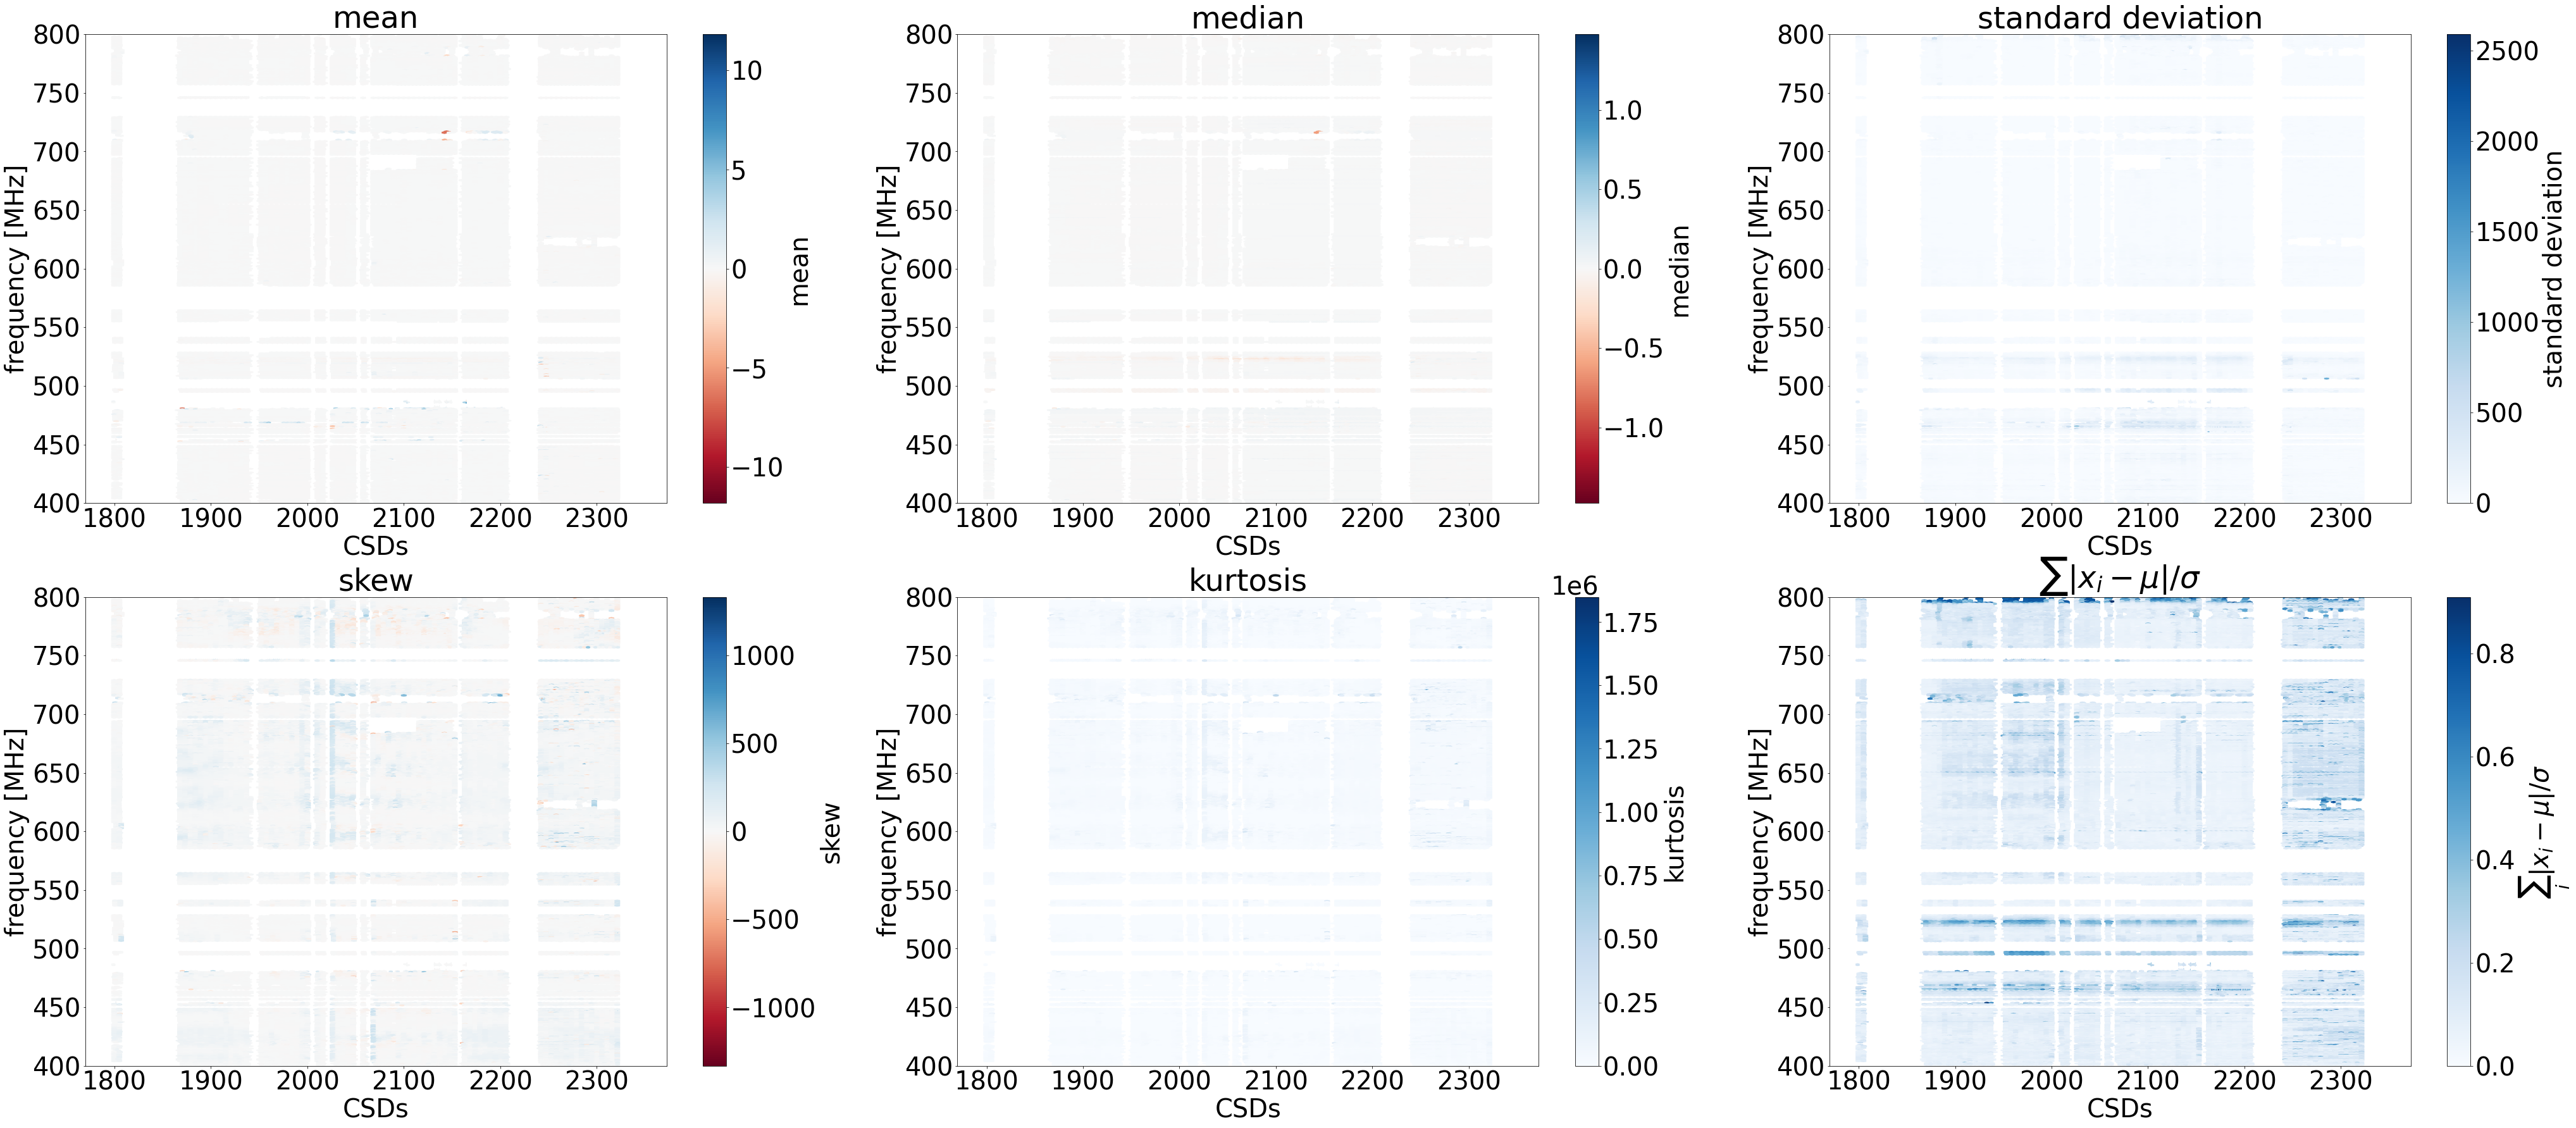

In [72]:
# waterfall

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize = (70, 30))

ax1.set_title('mean')
ax1.set_xlabel('CSDs')
ax1.set_ylabel('frequency [MHz]')
ax2.set_title('median')
ax2.set_xlabel('CSDs')
ax2.set_ylabel('frequency [MHz]')
ax3.set_title('standard deviation')
ax3.set_xlabel('CSDs')
ax3.set_ylabel('frequency [MHz]')
ax4.set_title('skew')
ax4.set_xlabel('CSDs')
ax4.set_ylabel('frequency [MHz]')
ax5.set_title('kurtosis')
ax5.set_xlabel('CSDs')
ax5.set_ylabel('frequency [MHz]')
ax6.set_title(r'$\sum{|x_i - \mu|/\sigma}$')
ax6.set_xlabel('CSDs')
ax6.set_ylabel('frequency [MHz]')

for k in range(1024):
    
    data = pd.read_csv('./rev01/stats_out/CSDs_stats_out_01_' + str(k) + '.txt')
    
    if len(data.CSD) == 0:
        continue
        
    if k == 230: #2270 zsum = '--'
        continue
    if k == 815: #2292 zsum = '--'
        continue
    if k == 860: #1910 zsum = '--'
        continue
    
    freq = freqs[k]
    
#     print(k, end = '\r')
    
    c1 = ax1.hexbin(x = data.CSD, y = [freq]*len(data.CSD), C = data['mean'], cmap = 'RdBu', vmin = min(min_mean), vmax = -min(min_mean))
    c2 = ax2.hexbin(x = data.CSD, y = [freq]*len(data.CSD), C = data['median'],cmap = 'RdBu', vmin = -max(max_median), vmax = max(max_median))
    c3 = ax3.hexbin(x = data.CSD, y = [freq]*len(data.CSD), C = data['stdev'], cmap = 'Blues', vmin = 0, vmax = max(max_stdev))
    c4 = ax4.hexbin(x = data.CSD, y = [freq]*len(data.CSD), C = data['skew'], cmap = 'RdBu', vmin = min(min_skew), vmax = -min(min_skew))
    c5 = ax5.hexbin(x = data.CSD, y = [freq]*len(data.CSD), C = data['kurtosis'], cmap = 'Blues', vmin = 0, vmax = max(max_kurtosis))
    c6 = ax6.hexbin(x = data.CSD, y = [freq]*len(data.CSD), C = data['zsum'], cmap = 'Blues', vmin = 0, vmax = max(max_zsum))
    
ax1.set_ylim([400, 800])   
ax2.set_ylim([400, 800])   
ax3.set_ylim([400, 800])   
ax4.set_ylim([400, 800])   
ax5.set_ylim([400, 800])
ax6.set_ylim([400, 800])
# ax1.set_xlim([1796, 2324])
# ax2.set_xlim([CSDs[0], CSDs[-1]])
# ax3.set_xlim([CSDs[0], CSDs[-1]])
# ax4.set_xlim([CSDs[0], CSDs[-1]])
# ax5.set_xlim([CSDs[0], CSDs[-1]])
# ax6.set_xlim([CSDs[0], CSDs[-1]])

fig.colorbar(c1, ax = ax1, label = 'mean')
fig.colorbar(c2, ax = ax2, label = 'median')
fig.colorbar(c3, ax = ax3, label = 'standard deviation')
fig.colorbar(c4, ax = ax4, label = 'skew')
fig.colorbar(c5, ax = ax5, label = 'kurtosis')
fig.colorbar(c6, ax = ax6, label = r'$\sum_i{|x_i - \mu|/\sigma}$')
# fig.savefig('rev01_waterfall.png', bbox_inches = 'tight', dpi = 300)    

In [77]:
mean_arr = []
median_arr = []
stdev_arr = []
skew_arr = []
kurtosis_arr = []
zsum_arr = []

freq_arr = []

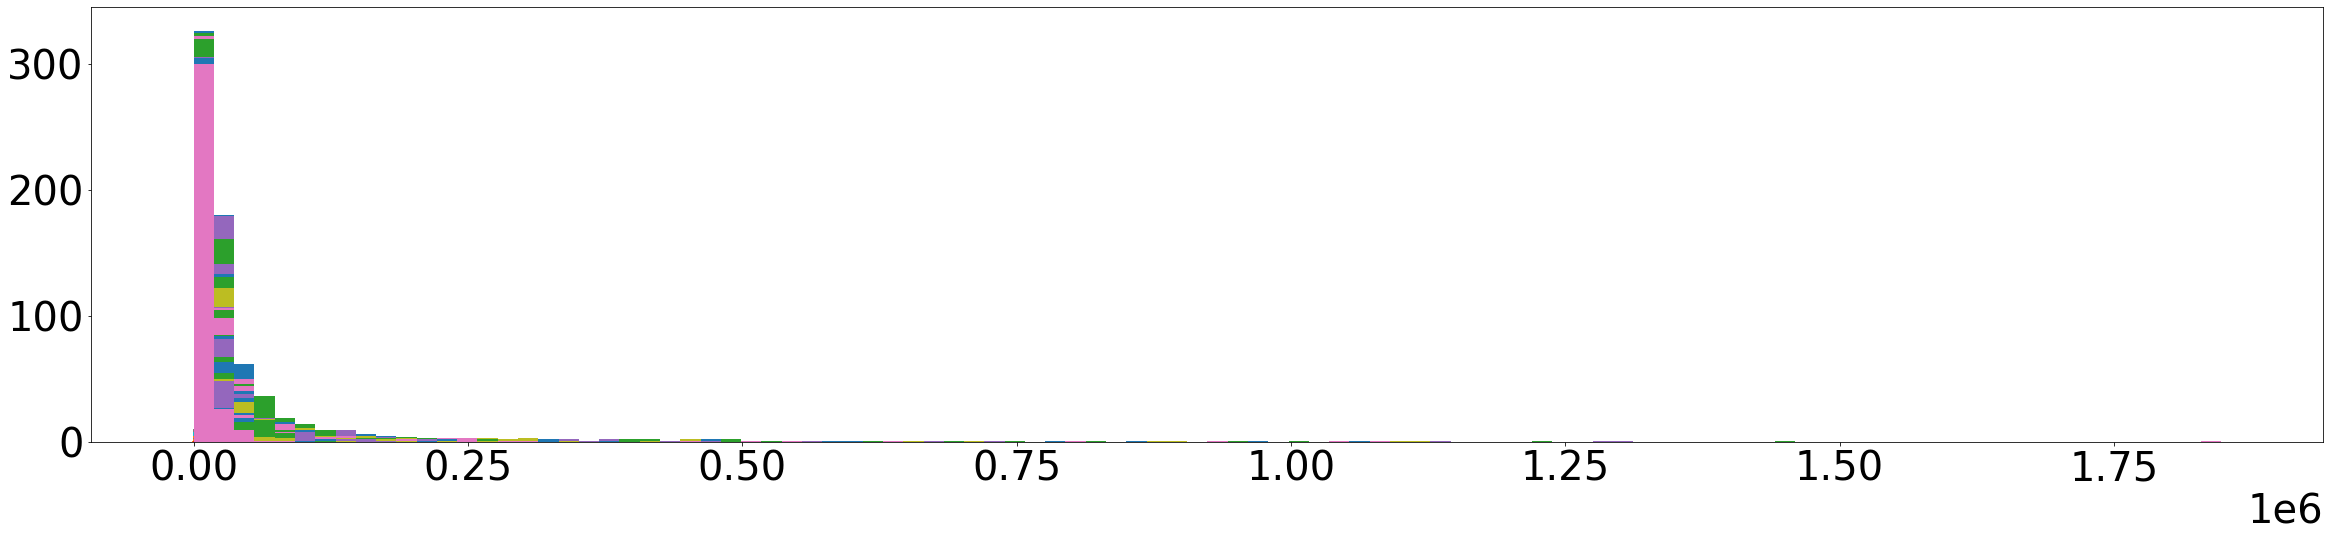

In [79]:
#multi-dimensional histogram

for k in range(1024):
    
    data = pd.read_csv('./rev01/stats_out/CSDs_stats_out_01_' + str(k) + '.txt')
    
    if len(data.CSD) == 0:
        continue
        
    if k == 230: #2270 zsum = '--'
        continue
    if k == 815: #2292 zsum = '--'
        continue
    if k == 860: #1910 zsum = '--'
        continue
    
    freq = freqs[k]
    
    
    (mean_n, mean_bins, patches) = plt.hist(data['mean'], bins=100, range= (min(min_mean), max(max_mean)))
    (median_n, median_bins, patches) = plt.hist(data['median'], bins=100, range= (min(min_median), max(max_median)))
    (stdev_n, stdev_bins, patches) = plt.hist(data['stdev'], bins=100, range= (min(min_stdev), max(max_stdev)))
    (skew_n, skew_bins, patches) = plt.hist(data['skew'], bins=100, range= (min(min_skew), max(max_skew)))
    (kurtosis_n, kurtosis_bins, patches) = plt.hist(data['kurtosis'], bins=100, range= (min(min_kurtosis), max(max_kurtosis)))
    (zsum_n, zsum_bins, patches) = plt.hist(data['zsum'], bins=100, range= (min(min_zsum), max(max_zsum)))
    
    
    mean_arr.append(mean_n)
    median_arr.append(median_n)
    stdev_arr.append(stdev_n)
    skew_arr.append(skew_n)
    kurtosis_arr.append(kurtosis_n)
    zsum_arr.append(zsum_n)

    freq_arr.append(freq)


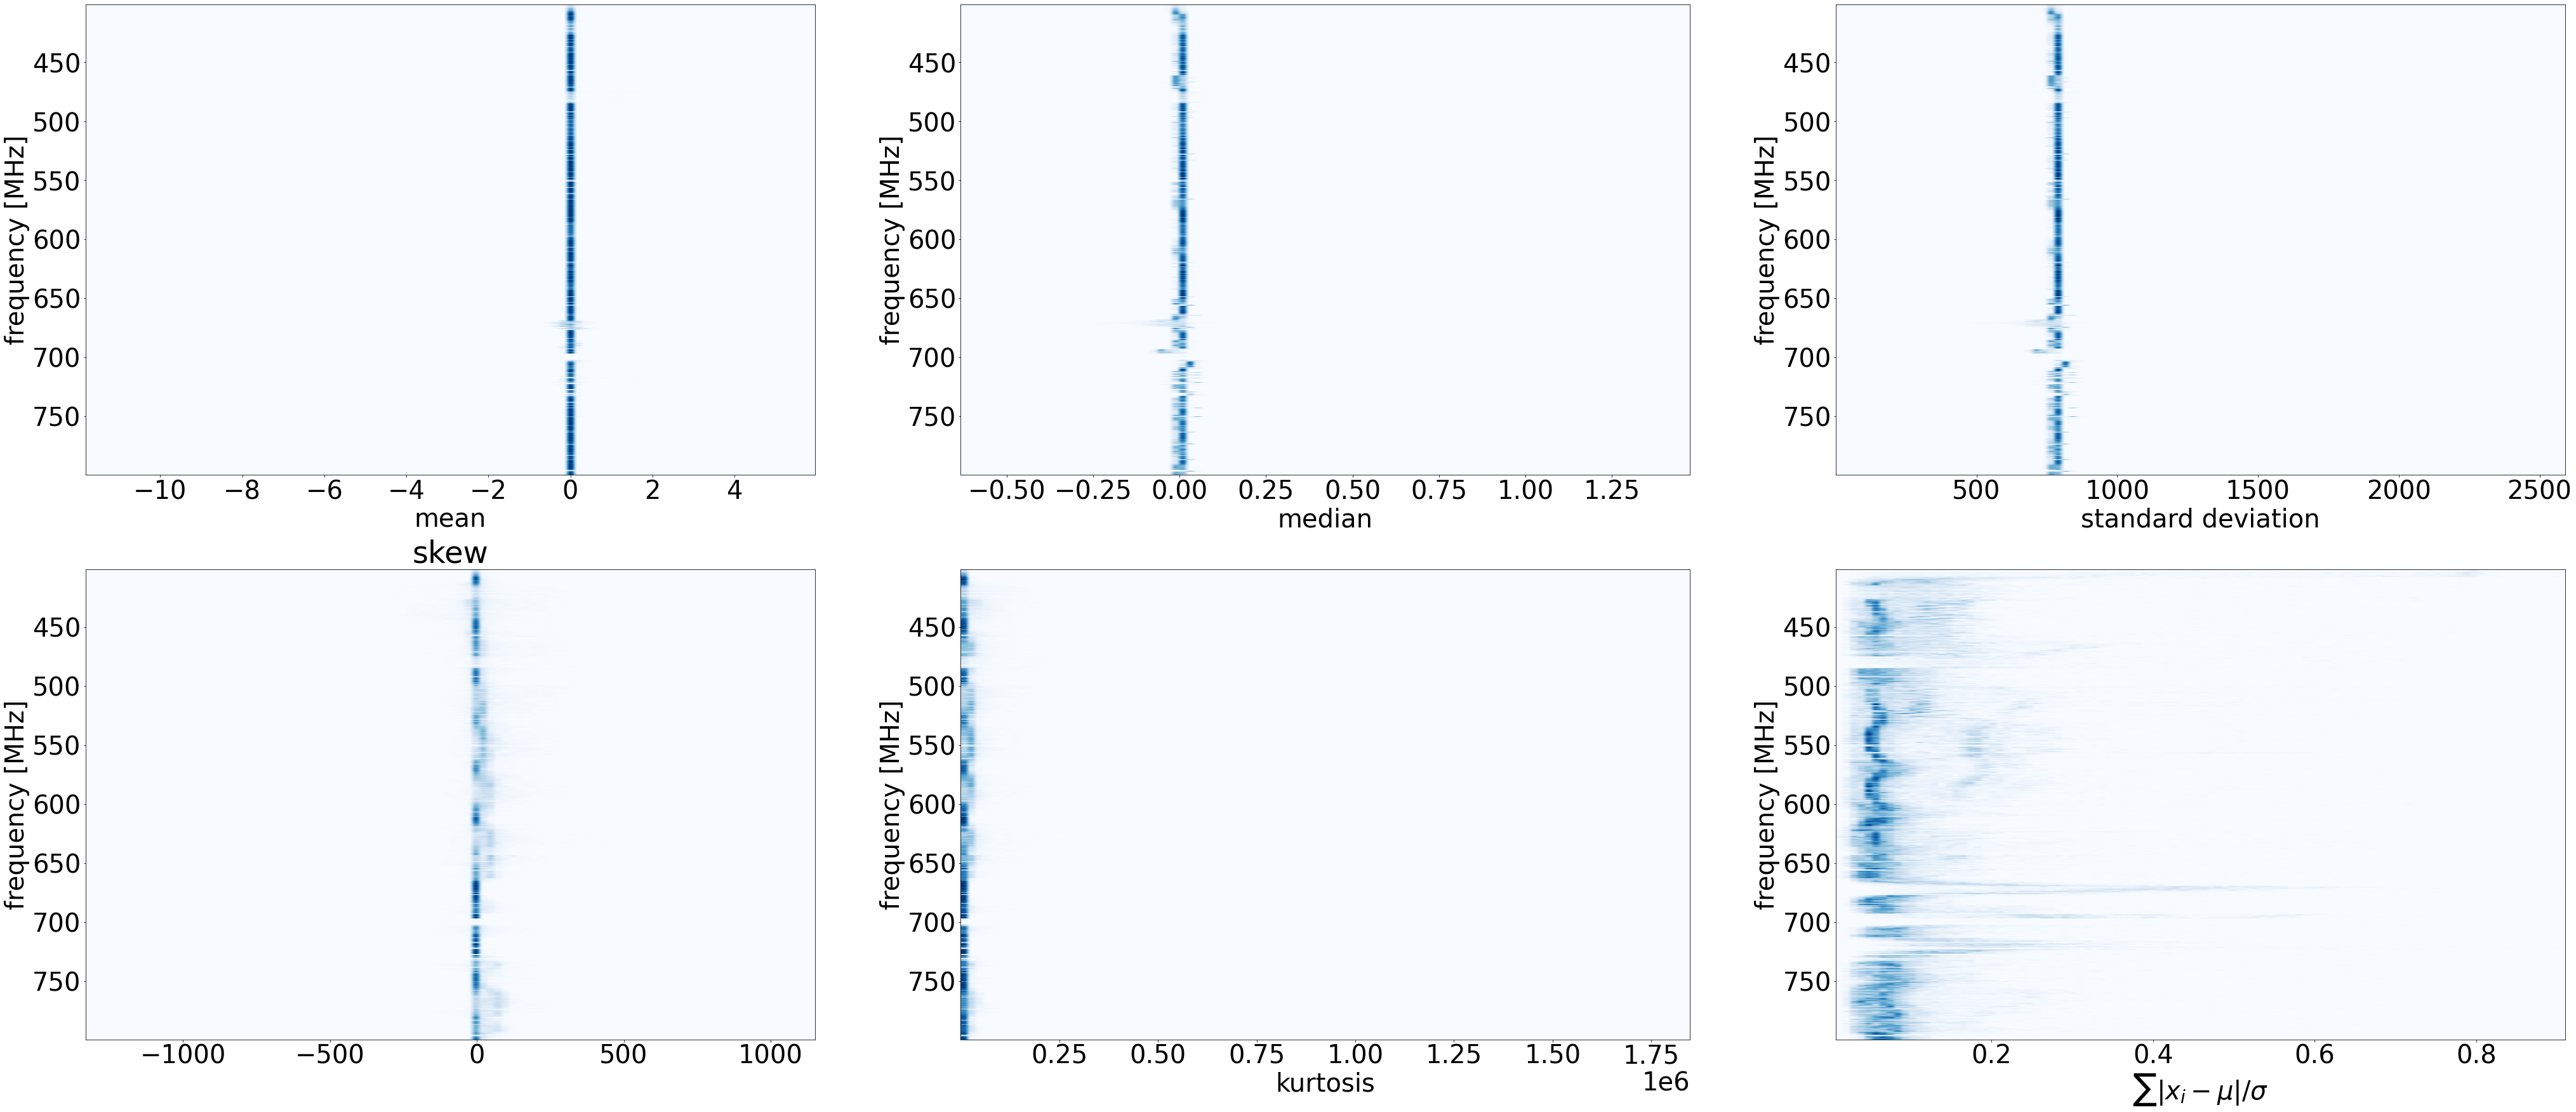

In [92]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize = (70, 30))

ax1.set_xlabel('mean')
# ax1.set_xlabel('CSDs')
ax1.set_ylabel('frequency [MHz]')
ax2.set_xlabel('median')
# ax2.set_xlabel('CSDs')
ax2.set_ylabel('frequency [MHz]')
ax3.set_xlabel('standard deviation')
# ax3.set_xlabel('CSDs')
ax3.set_ylabel('frequency [MHz]')
ax4.set_title('skew')
# ax4.set_xlabel('CSDs')
ax4.set_ylabel('frequency [MHz]')
ax5.set_xlabel('kurtosis')
# ax5.set_xlabel('CSDs')
ax5.set_ylabel('frequency [MHz]')
ax6.set_xlabel(r'$\sum{|x_i - \mu|/\sigma}$')
# ax6.set_xlabel('CSDs')
ax6.set_ylabel('frequency [MHz]')


c1 = ax1.imshow(mean_arr, cmap = 'Blues', aspect = 'auto', extent = [mean_bins[0], mean_bins[-1], freq_arr[0], freq_arr[-1]])#, vmin = 0, vmax = 0.5)
c2 = ax2.imshow(median_arr, cmap = 'Blues', aspect = 'auto', extent = [median_bins[0], median_bins[-1], freq_arr[0], freq_arr[-1]])#, vmin = 0, vmax = 0.5)
c3 = ax3.imshow(median_arr, cmap = 'Blues', aspect = 'auto', extent = [stdev_bins[0], stdev_bins[-1], freq_arr[0], freq_arr[-1]])#, vmin = 0, vmax = 0.5)
c4 = ax4.imshow(skew_arr, cmap = 'Blues', aspect = 'auto', extent = [skew_bins[0], skew_bins[-1], freq_arr[0], freq_arr[-1]])#, vmin = 0, vmax = 0.5)
c5 = ax5.imshow(kurtosis_arr, cmap = 'Blues', aspect = 'auto', extent = [kurtosis_bins[0], kurtosis_bins[-1], freq_arr[0], freq_arr[-1]])#, vmin = 0, vmax = 0.5)
c6 = ax6.imshow(zsum_arr, cmap = 'Blues', aspect = 'auto', extent = [zsum_bins[0], zsum_bins[-1], freq_arr[0], freq_arr[-1]])#, vmin = 0, vmax = 0.5)

fig.savefig('rev01_hist_waterfall.png', bbox_inches = 'tight', dpi = 300)

In [ ]:
#pairplot
import seaborn as sns
frequency = 107

dat = pd.read_csv('./rev01/stats_out/CSDs_stats_out_01_' + str(frequency) + '.txt')
sns.set(font_scale=2, palette = 'gray')
sns.pairplot(dat, kind = 'kde', height = 4, aspect = 1)
